# Train rotationally invariant CNN model on MNIST data with rotations

Here, we take the MNIST data set and rotate the images over multiples of 90 degrees. (Note that this will lead to ambiguities, e.g. a rotated 6 can be identical to a 9.)

To classify these dataset, we construct and train two models:

- a normal CNN which is translational invariant, but not rotational invariant.
- a rotationally invariant CNN based on group convolutions [1, 2].

My expectation is that the GCNN will require less training samples (i.e. leads to faster convergence) and requires less parameters (filters). 


For the rotationally invarient CNN, we use Bas Veeling's Keras GCNN implementation: [keras-gcnn](https://github.com/basveeling/keras-gcnn).

[1] B. S. Veeling, J. Linmans, J. Winkens, T. Cohen, M. Welling. "[Rotation Equivariant CNNs for Digital Pathology](http://arxiv.org/abs/1806.03962)". arXiv (2018).

[2] Cohen, Taco, and Max Welling. "[Group equivariant convolutional networks](https://tacocohen.files.wordpress.com/2016/06/gcnn.pdf)." International Conference on Machine Learning. 2016.

## Links: 
- Keras-GCNN https://github.com/basveeling/keras-gcnn

- Presentation by Taco Cohen (see 27:00): https://archive.org/details/Redwood_Center_2016_06_27_Taco_Cohen
  


In [1]:
import keras
from keras.datasets import mnist
from keras import backend as K
import numpy as np

# input image dimensions
img_rows, img_cols = 28, 28
num_classes = 10

Using TensorFlow backend.


# Data

In [2]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


- rotate images randomly by 90 degrees

In [3]:
# rotate images by random 90 degree rotations
x_train = np.array([np.rot90(im, k=np.random.randint(0,4)) for im in x_train])
x_test  = np.array([np.rot90(im, k=np.random.randint(0,4)) for im in x_test])


In [4]:
def plot_samples(x, y):
    
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(8,8,figsize=(12,12))
    ax = ax.flatten()
    for a in ax:
        index = np.random.choice(len(x))
        im = np.squeeze(x[index])
        a.imshow(im, cmap='gray_r')
        a.set_title(np.argmax(y[index]))
        a.axis('off')
    plt.show()
    plt.close()


In [5]:
plot_samples(x_train, y_train)

<Figure size 1200x1200 with 64 Axes>

# Models

In [6]:
def get_CNN_model(n_init_filters=32):
    from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense
    from keras.models import Model
    
    i = Input((None, None, 1))
    
    x = Conv2D(filters=n_init_filters, kernel_size=(3,3), padding='valid')(i)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    x = Conv2D(filters=n_init_filters*2, kernel_size=(3,3), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(units=n_init_filters*2, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    o = Dense(units=10, activation='softmax')(x)

    return Model(inputs=i, outputs=o)


In [7]:
model1 = get_CNN_model(n_init_filters=64)
model1.count_params()
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 1)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    640       
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 64)    256       
_________________________________________________________________
activation_1 (Activation)    (None, None, None, 64)    0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 128)   73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, None, 128)   512       
__________

Now, we construct a group-equivariant version of this network following the [recipe](https://github.com/basveeling/keras-gcnn#recipe-for-building-equivariant-networks):

- Decide on a group to use, currently D4 (roto-reflection) and C4 (rotations) are supported.
- All convolutional layers with kernels larger than 1 should be replaced with group-equivariant layers.
  - The first layer transforms the input from Z2 to D4, by setting h_input='Z2' and h_output='C4' or 'D4'.
  - Follow up layers live on the chosen group and have h_input=h_output='D4' (or 'C4').
- Operations that learn parameters per feature-map should be replaced with group versions, including:
  - BatchNormalization becomes GBatchNorm.
- To create a model invariant to rotations, use GroupPool followed by a global spatial pooling layer such as GlobalAveragePooling.


Additionally, we divide the number of filters per layer by the square root of the size of the group, i.e. for 'C4' rotations, $\sqrt 4=2$, as proposed in [2](https://tacocohen.files.wordpress.com/2016/06/gcnn.pdf).

In [8]:
def get_GCNN_model(n_init_filters, h):
    from keras.layers import Input, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
    from keras.models import Model
    from keras_gcnn.layers import GConv2D, GBatchNorm
    from keras_gcnn.layers.pooling import GroupPool
    
    i = Input((None, None, 1))
    
    x = GConv2D(filters=n_init_filters, kernel_size=(3,3), h_input='Z2', h_output=h, padding='valid')(i) # first GConv2D layer transforms from 'Z2' to 'C4'
    x = GBatchNorm(h=h)(x) # BatchNormalization -> GBatchNorm
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    x = GConv2D(filters=n_init_filters*2, kernel_size=(3,3), h_input=h, h_output=h, padding='valid')(x) # following GConv2D layer transform from 'C4' to 'C4'
    x = GBatchNorm(h=h)(x) # BatchNormalization -> GBatchNorm
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = GroupPool(h_input=h)(x) # GroupPool followed by GlobalAveragePooling
    x = GlobalAveragePooling2D()(x)
    x = Dense(units=n_init_filters*2, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    o = Dense(units=10, activation='softmax')(x)

    return Model(inputs=i, outputs=o)

In [9]:
model2 = get_GCNN_model(n_init_filters=64//int(np.sqrt(4)), h='C4')
model2.count_params()
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 1)     0         
_________________________________________________________________
g_conv2d_1 (GConv2D)         (None, None, None, 128)   288       
_________________________________________________________________
g_batch_norm_1 (GBatchNorm)  (None, None, None, 128)   128       
_________________________________________________________________
activation_3 (Activation)    (None, None, None, 128)   0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, None, None, 128)   0         
_________________________________________________________________
g_conv2d_2 (GConv2D)         (None, None, None, 256)   73728     
_________________________________________________________________
g_batch_norm_2 (GBatchNorm)  (None, None, None, 256)   256       
__________

In [10]:
print(f'GCNN has {model2.count_params() / model1.count_params():.2f} times the number of parameters of CNN model')

GCNN has 0.85 times the number of parameters of CNN model


# Train

In [11]:
models = {'CNN': model1, 
          'GCNN': model2}

In [12]:
batch_size = 512
epochs = 50

In [13]:
histories = {}
for name,model in models.items():
    print(f'\n============ {name} ============\n')
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])

    h = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=0,
              validation_data=(x_test, y_test))
    histories[name] = h
    
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])


============ CNN ============

Test loss: 0.6116267810225486
Test accuracy: 0.8166

============ GCNN ============

Test loss: 0.5633816869854927
Test accuracy: 0.8244


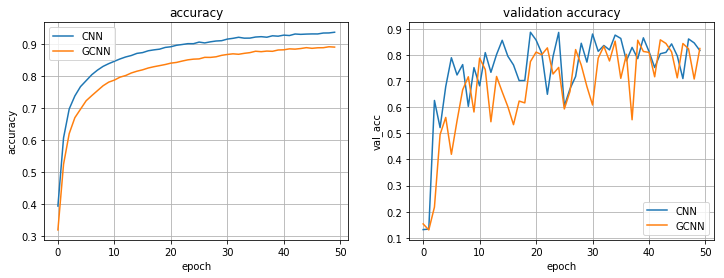

In [14]:
def plot_histories():
    
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1,2,figsize=(12,4))
    
    for name,h in histories.items():
        ax[0].plot(h.history['acc'], label=name)
        ax[0].set_xlabel('epoch')
        ax[0].set_ylabel('accuracy')
        ax[0].set_title('accuracy')
        ax[0].legend()
        ax[0].grid(True)
        
    for name,h in histories.items():
        ax[1].plot(h.history['val_acc'], label=name)
        ax[1].set_xlabel('epoch')
        ax[1].set_ylabel('val_acc')
        ax[1].set_title('validation accuracy')
        ax[1].legend()
        ax[1].grid(True)
        
plot_histories()

## Result

- Although 90-degree rotated MNIST images should be easier to learn with group-convolutions, GCNN does not outperform CNN on this dataset.
- GCNN does not converge faster, and remains to have lower accuracy on training set.
- Validation accuracy seems comparable.

## Question

- What did I do wrong in converting the CNN into a GCNN?